In [1]:
!pip install tensorflow

In [2]:
#1. Izpišite koliko je vseh slik v mapi data.
import pathlib
import numpy as np
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

pot = pathlib.Path("data")
st_slik = len(list(pot.glob('*/*.jpg')))
print("Število vseh slik: " + str(st_slik))

Število vseh slik: 2406


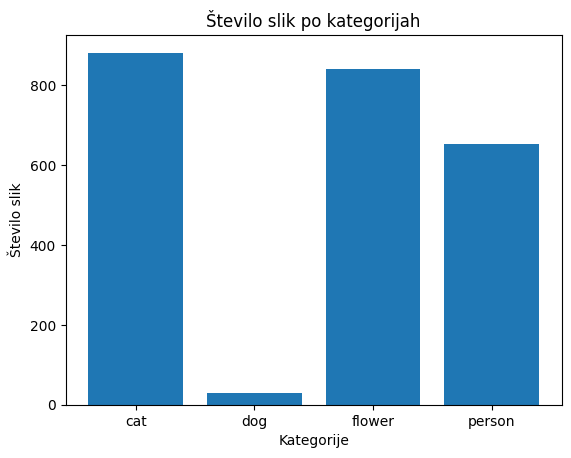

In [3]:
#2. Izrišite graf na katerem prikažete koliko je slik v posamezni kategoriji oz.
# koliko slik pripada posameznemu razredu
import matplotlib.pyplot as plt
from pathlib import Path

# Seznam map za različne kategorije
kategorije = ["cat", "dog", "flower", "person"]

# Seznam za shranjevanje števila slik v vsaki kategoriji
stevilo_slik = []

# Preštejte število slik v vsaki kategoriji
for kategorija in kategorije:
    slike = list(pot.glob(f"{kategorija}/*"))
    stevilo_slik.append(len(slike))

# Ustvarite stolpčni graf
plt.bar(kategorije, stevilo_slik)

# Nastavite naslov in oznake osi
plt.title("Število slik po kategorijah")
plt.xlabel("Kategorije")
plt.ylabel("Število slik")

# Prikažite graf
plt.show()


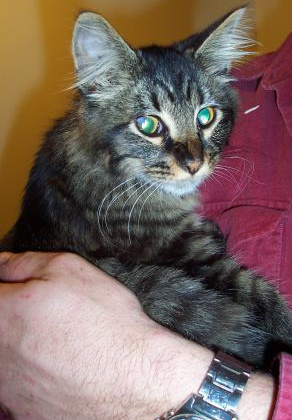

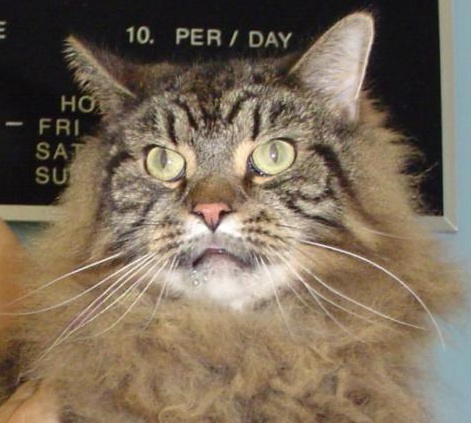

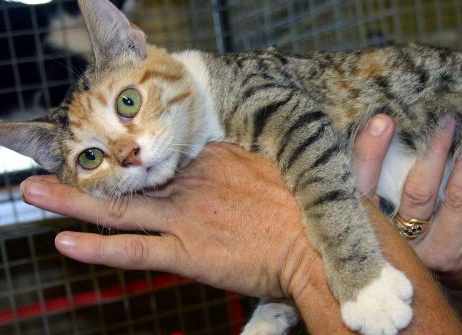

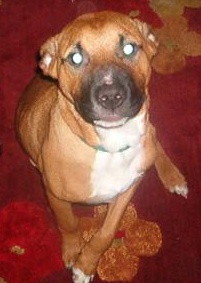

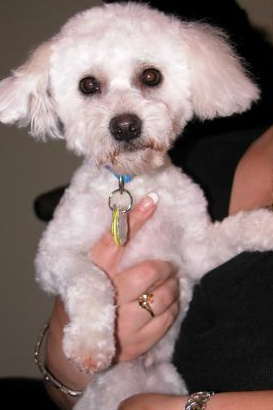

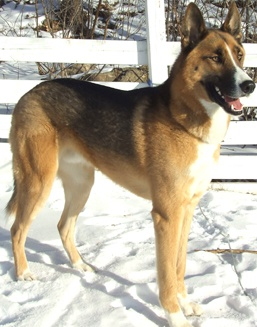

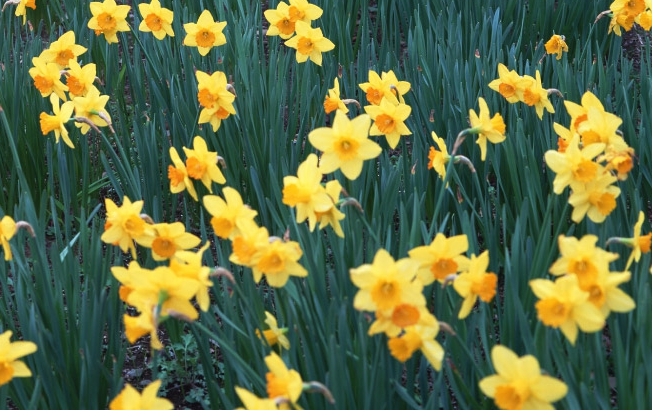

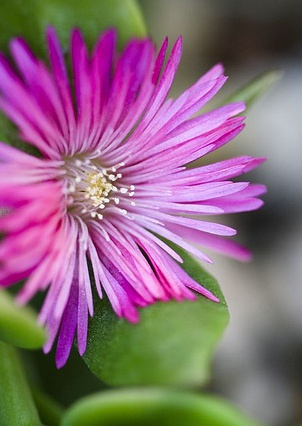

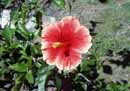

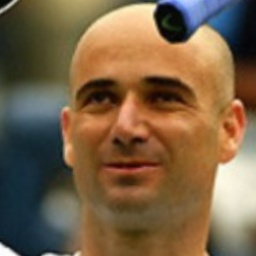

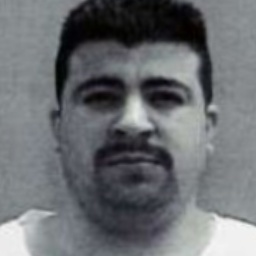

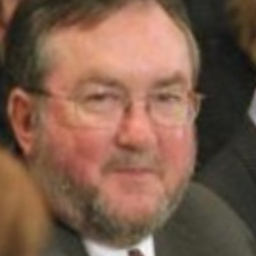

In [4]:
#3. Preverite kakšne slike so shranjene v obstoječih mapah,
# tako da izpišete po 3 primerke za vsak posamezen razred.
from PIL import Image
from IPython.display import display
import os
# Specify the number of sample images to display for each category
num_samples = 3

# Iterate through each category and display the sample images
for category in kategorije:
    category_path = os.path.join(pot, category)

    # List image files in the category directory and take the first 3
    image_files = os.listdir(category_path)[:num_samples]

    for image_file in image_files:
        image_path = os.path.join(category_path, image_file)
        img = Image.open(image_path)
        display(img)


In [5]:
#4. Obstoječe podatke (iz mape data) razdelite v testni in
# validacijski dataset, glede na naključno stanje 123. Velikost učne množice naj bo 70%.
# Vsem slikam spremenite velikost na 120x120. Velikost serije (batch size) naj bo 25.
#pot = pathlib.Path("data")
path = pathlib.Path("test")
img_height = 120
img_width = 120
batch_size = 25
#razdelitev podatkov
train = tf.keras.preprocessing.image_dataset_from_directory(pot,
                                                            validation_split=0.3, #velikost validacijske množice je 30%
                                                            subset="training", #povemo da tu želimo pridobiti slike za učno množico
                                                            seed=123,
                                                            image_size=(img_height, img_width), #spremenimo velikost slik
                                                            batch_size=batch_size) #nastavimo velikost serije

Found 2406 files belonging to 4 classes.
Using 1685 files for training.


In [6]:
validation = tf.keras.preprocessing.image_dataset_from_directory(pot,
                                                                 validation_split=0.3, #velikost validacijske množice je 30%
                                                                 subset="validation", #povemo da tu želimo pridobiti slike za validacijsko množico
                                                                 seed=123,
                                                                 image_size=(img_height, img_width), #spremenimo velikost slik
                                                                 batch_size=batch_size) #nastavimo velikost serije

Found 2406 files belonging to 4 classes.
Using 721 files for validation.


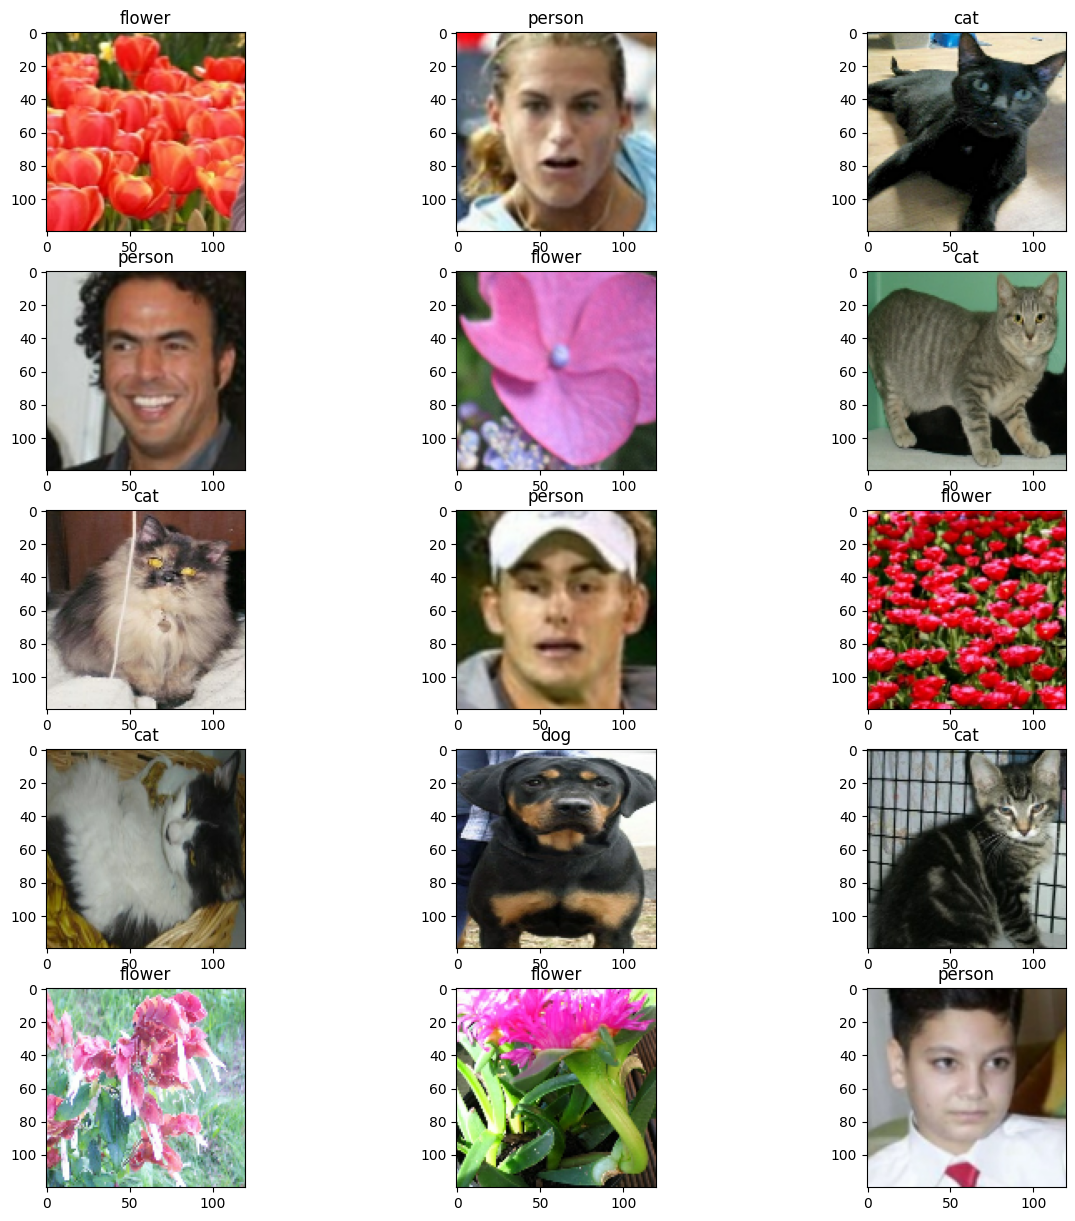

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15)) #nastavimo velikost slik za prikaz
for images, labels in train.take(1):
    for i in range(15): #izpišemo 15 slik
        ax = plt.subplot(5, 3, i + 1) #izpišemo 5 slik v eni vrstici
        plt.imshow(images[i].numpy().astype("uint8")) #prikažemo sliko
        plt.title(kategorije[labels[i]]) #pikažemo napis nad sliko

In [8]:
#6. Izpišite kakšni so izhodni razredi slik iz prve serije (batch-a).
for image_batch, labels_batch in train:
    print(labels_batch.shape)
    print(labels_batch) #izpis razredov za prvo serijo (batch)
    break

(25,)
tf.Tensor([0 3 3 2 2 3 0 3 3 2 2 1 3 2 0 0 2 3 3 2 2 2 0 3 3], shape=(25,), dtype=int32)


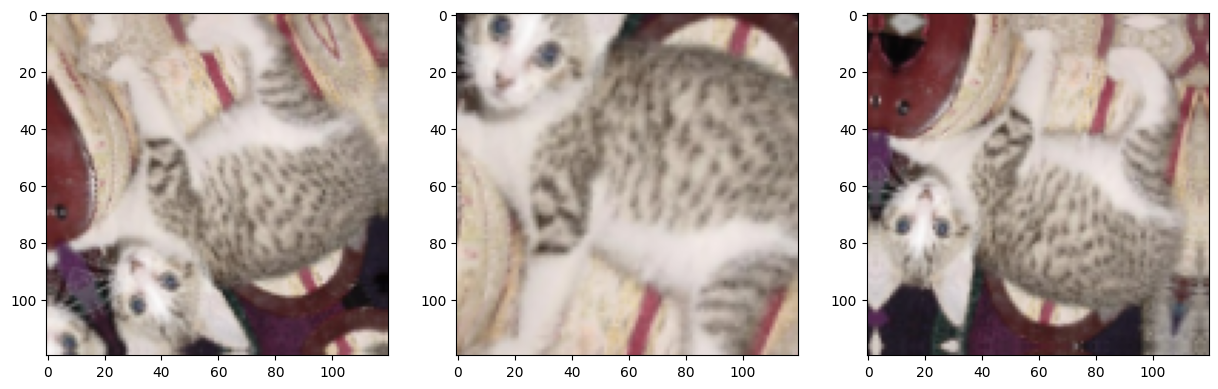

In [10]:
# 7. Nad slikami izvedite augmentacijo tako da jih obrnete glede na
#  vertikalno os ter jih zavrtite in približate za vrednost 0,3.
# Augmentacijo lahko izvedete predhodna nad slikami, ali jo vključite v model.
# Pazite, da jo izvedete samo enkrat.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
])

plt.figure(figsize=(15, 15))
for images, _ in train.take(1):
    for i in range(3):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))


In [11]:
# 8. Standardizirajte podatke (standardizacijo lahko izvedete neposredno nad datasetom s slikami ali
#pa jo vključite kot samostojno raven v model).
from tensorflow.keras.models import Sequential

st_razredov = 4

model = Sequential()
model.add(layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height,img_width,3))) #data augmentation
model.add(layers.experimental.preprocessing.RandomRotation(0.1)) #data augmentation
model.add(layers.experimental.preprocessing.RandomZoom(0.1)) #data augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))) #standardizacija podatkov
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(st_razredov))

In [12]:
# 9. Ustvarite Sequential model, ki bo vseboval dva bloka s konvolucijskimi nevronskimi mrežami.
# Prvi blok naj ima vrednost filters nastavljeno na 32, drugi pa na 64. kernel_size naj bo pri obeh 3,
#  prav tako naj imata ob aktivacijsko funkcijo 'relu', vsakemu pa naj sledi raven MaxPooling2D.
#  Za zadnjim MaxPooling-om dodajte Dropout raven z vrednostjo 0,2. Kot zadnji dodajte še Flatten in Dense raven.
from tensorflow import keras
from tensorflow.keras import layers

# Create a Sequential model
model = keras.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Dropout layer
model.add(layers.Dropout(0.2))

# Flatten layer
model.add(layers.Flatten())

# Dense layer
model.add(layers.Dense(st_razredov))  # Adjust st_razredov to the number of classes in your task


In [13]:
# 10. Delovanje optimizirajte z optimizatorjem adam, za računanje loss funkcije uporabite
#  SparseCategoricalCrossentropy ter merite točnost napovedi.
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [14]:
# 11. Izpišite podrobnosti modela.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 59, 59, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 50176)            

In [16]:
# 12. Model učite na 20 iteracijah (epoch-ah).
epochs=20
rezultati = model.fit(train, validation_data=validation, epochs=epochs)

Epoch 1/20
68/68 [==============================] - 39s 543ms/step - loss: 27.0159 - accuracy: 0.6427 - val_loss: 0.6510 - val_accuracy: 0.8031
Epoch 2/20
68/68 [==============================] - 36s 522ms/step - loss: 0.3628 - accuracy: 0.8878 - val_loss: 0.4756 - val_accuracy: 0.8835
Epoch 3/20
68/68 [==============================] - 38s 551ms/step - loss: 0.2794 - accuracy: 0.9211 - val_loss: 0.5774 - val_accuracy: 0.8308
Epoch 4/20
68/68 [==============================] - 36s 529ms/step - loss: 0.1620 - accuracy: 0.9448 - val_loss: 0.5732 - val_accuracy: 0.8807
Epoch 5/20
68/68 [==============================] - 36s 527ms/step - loss: 0.0792 - accuracy: 0.9780 - val_loss: 0.6327 - val_accuracy: 0.9001
Epoch 6/20
68/68 [==============================] - 35s 519ms/step - loss: 0.0952 - accuracy: 0.9685 - val_loss: 0.6280 - val_accuracy: 0.8474
Epoch 7/20
68/68 [==============================] - 35s 515ms/step - loss: 0.1156 - accuracy: 0.9733 - val_loss: 0.6303 - val_accuracy: 0.862

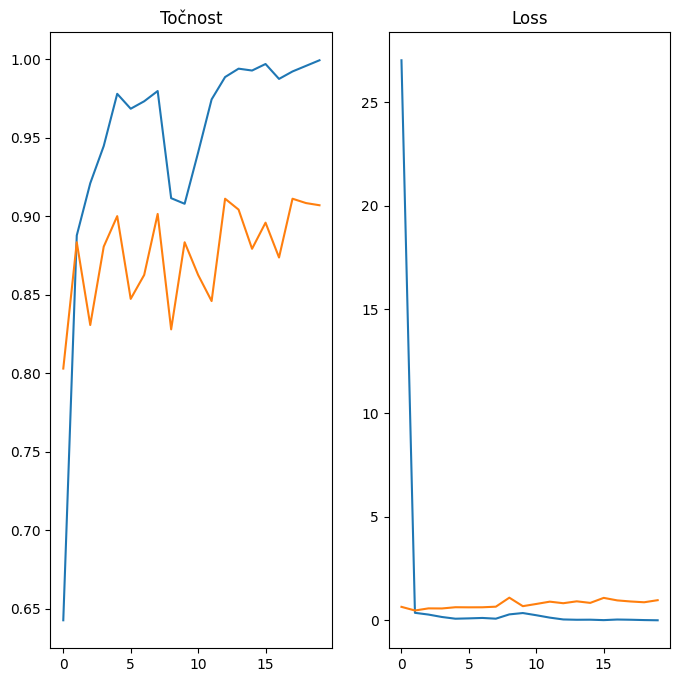

In [17]:
# 13. V obliki grafa izpišite kako se je spreminjala točnost tekom posameznih iteracij nad učno in validacijsko množico.
tocnost_train = rezultati.history['accuracy']
tocnost_val = rezultati.history['val_accuracy']

loss_train = rezultati.history['loss']
loss_val= rezultati.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, tocnost_train, label='Učna množica')
plt.plot(epochs_range, tocnost_val, label='Validacijska množica')
plt.title('Točnost')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_train, label='Učna množica')
plt.plot(epochs_range, loss_val, label='Validacijska množica')
plt.title('Loss')
plt.show()

1/1 [==============================] - 0s 115ms/step
person, napovedano s 72.7680504322052 % točnostjo


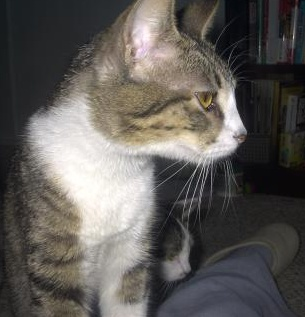

1/1 [==============================] - 0s 25ms/step
cat, napovedano s 100.0 % točnostjo


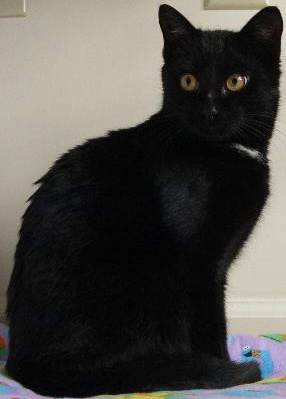

1/1 [==============================] - 0s 47ms/step
cat, napovedano s 100.0 % točnostjo


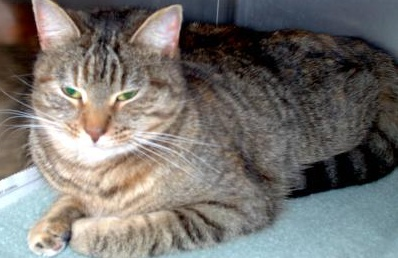

1/1 [==============================] - 0s 43ms/step
cat, napovedano s 99.99953508377075 % točnostjo


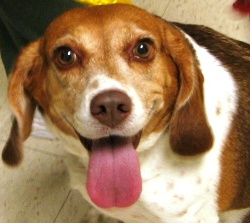

1/1 [==============================] - 0s 43ms/step
cat, napovedano s 100.0 % točnostjo


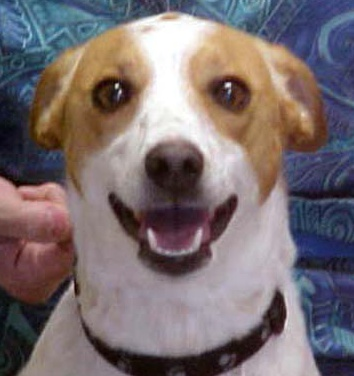

1/1 [==============================] - 0s 35ms/step
cat, napovedano s 99.52540397644043 % točnostjo


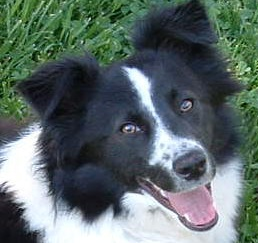

1/1 [==============================] - 0s 36ms/step
flower, napovedano s 100.0 % točnostjo


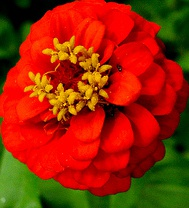

1/1 [==============================] - 0s 40ms/step
flower, napovedano s 100.0 % točnostjo


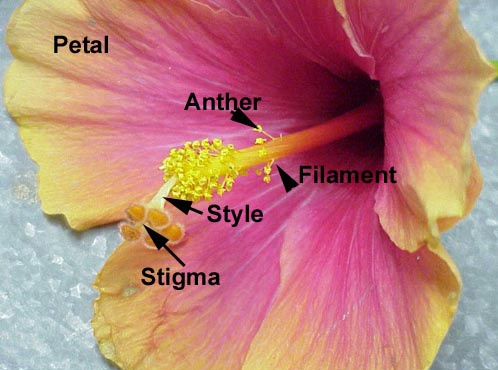

1/1 [==============================] - 0s 47ms/step
flower, napovedano s 100.0 % točnostjo


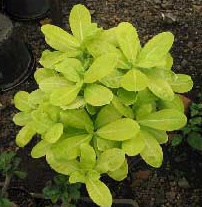

1/1 [==============================] - 0s 41ms/step
person, napovedano s 100.0 % točnostjo


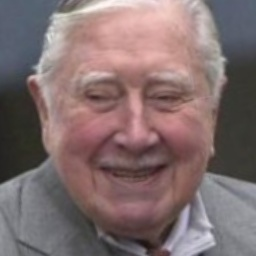

1/1 [==============================] - 0s 58ms/step
person, napovedano s 100.0 % točnostjo


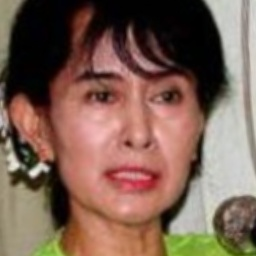

In [18]:
# 14. Za vse slike, ki niso bile uporabljene v postopku učenja modela, preverite v katere razrede
# in s kakšno natančnostjo jih razvrsti uporabljena klasifikacija. Glede na število pravilno in
# nepravilno razvrščenih slik zapišite kako točna je bila klasifikacija.
for i in range(1,12):
    img = keras.preprocessing.image.load_img("test/"+str(i)+".jpg", target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    napovedi = model.predict(img_array)
    tocnost = tf.nn.softmax(napovedi[0])

    print(kategorije[np.argmax(tocnost)] + ", napovedano s " + str(100 * np.max(tocnost)) + " % točnostjo")
    display(PIL.Image.open(str("test/"+str(i)+".jpg")))
    i=i+1